<a href="https://colab.research.google.com/github/Nguyen-The-Thanh/NguyenTheThanh_training_FMlab/blob/main/Homeworks/Hw4/2_decision_tree_random_forest_BTVN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bài tập về nhà Decision Tree, Random Forest


- Thực hiện các yêu cầu dưới đây với tập dữ liệu Australian credit
- Down dữ liệu tại đường link dưới đây và đặt vào folder /data

  https://archive.ics.uci.edu/ml/datasets/Statlog+(Australian+Credit+Approval)
    

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

random_state = 0


## 1. Tìm hiểu dữ liệu

In [2]:
'''
- Tìm hiểu cấu trúc data tại trang web UCI
- Down các files, đặt trong folder data/
- Làm với phiên bản 'numeric'
'''
data_path = './data/australian.dat'
credit=np.genfromtxt(data_path)
credit = pd.DataFrame(data=credit)
credit.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','Y']
print(credit.head())

X = credit.iloc[:, :-1].values
y = credit.iloc[:, -1].values

# Onehot encode categorical columns
encode_rules = ColumnTransformer(
    transformers=[('one_hot_encoder', OneHotEncoder(categories='auto'), [3,4,5,11])],
    remainder='passthrough'
)

X = encode_rules.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=random_state)
print(X_train.shape, X_test.shape)


    X1     X2     X3   X4   X5   X6     X7   X8   X9   X10  X11  X12    X13  \
0  1.0  22.08  11.46  2.0  4.0  4.0  1.585  0.0  0.0   0.0  1.0  2.0  100.0   
1  0.0  22.67   7.00  2.0  8.0  4.0  0.165  0.0  0.0   0.0  0.0  2.0  160.0   
2  0.0  29.58   1.75  1.0  4.0  4.0  1.250  0.0  0.0   0.0  1.0  2.0  280.0   
3  0.0  21.67  11.50  1.0  5.0  3.0  0.000  1.0  1.0  11.0  1.0  2.0    0.0   
4  1.0  20.17   8.17  2.0  6.0  4.0  1.960  1.0  1.0  14.0  0.0  2.0   60.0   

      X14    Y  
0  1213.0  0.0  
1     1.0  0.0  
2     1.0  0.0  
3     1.0  1.0  
4   159.0  1.0  
(552, 38) (138, 38)


## 2. Decision Tree

### 2.1. Khảo sát với các giá trị khác nhau của max_depth

Text(0.5, 1.0, 'DT validation curve for max_depth')

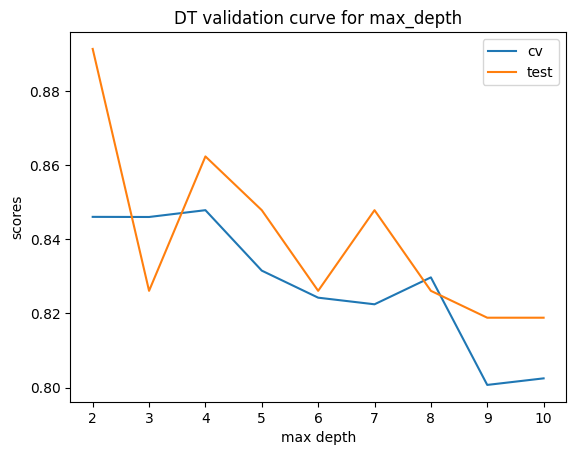

In [3]:
cv_accuracies_by_depth, test_accuracies_by_depth= [], []
max_depth_values= np.arange(2,11)

for curr_max_depth in max_depth_values:
  tree= DecisionTreeClassifier(random_state=random_state, max_depth=curr_max_depth)

  # cross-validation
  val_scores= cross_val_score(estimator=tree, X=X_train, y=y_train, cv=5, scoring='accuracy')
  cv_accuracies_by_depth.append(val_scores.mean())

  # test
  tree.fit(X_train, y_train)
  curr_pred= tree.predict(X_test)
  test_accuracies_by_depth.append(accuracy_score(curr_pred, y_test))

# Plot
plt.plot(max_depth_values, cv_accuracies_by_depth, label='cv')
plt.plot(max_depth_values, test_accuracies_by_depth, label='test')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('scores')
plt.title('DT validation curve for max_depth')

### 2.2. Parameter tuning    

In [4]:
parameter={
    'max_depth': [2, 3, 4, 5, 6, 7],
    'min_samples_split' : np.arange(2,202,20),
    'min_samples_leaf' : np.arange(1,201,20),
    'max_leaf_nodes': (2, 5, 10, 20, 50),
    'class_weight': ['balanced', None]
}
grid=GridSearchCV(DecisionTreeClassifier(), parameter, verbose=1, n_jobs=-1)
gridfit=grid.fit(X_train,y_train)
print(gridfit.best_params_)
y_pred = gridfit.predict(X_test)
print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 6000 candidates, totalling 30000 fits
{'class_weight': None, 'max_depth': 4, 'max_leaf_nodes': 5, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2)}
0.8623188405797102


## 3. Random Forest

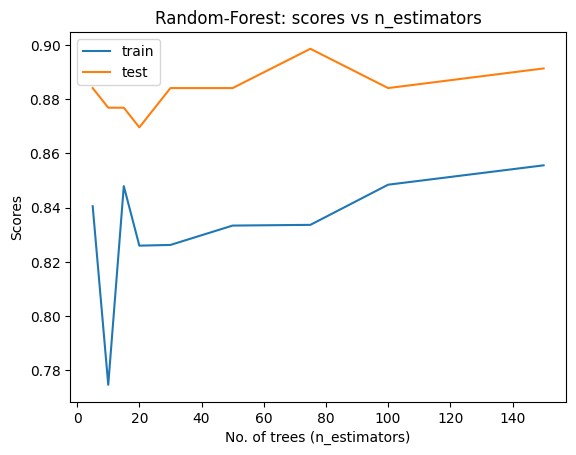

In [5]:
num_trees = [5, 10, 15, 20, 30, 50, 75, 100, 150]
train_acc = []
test_acc = []
for ntrees in num_trees:
    rf = RandomForestClassifier(n_estimators=ntrees, random_state=random_state, n_jobs=-1).fit(X_train, y_train)
    temp_train_acc=cross_val_score(rf, X_test, y_test, cv=5, scoring='accuracy')
    train_acc.append(temp_train_acc.mean())
    test_acc.append(accuracy_score(rf.predict(X_test), y_test))
plt.plot(num_trees, train_acc, label='train')
plt.plot(num_trees, test_acc, label='test')
plt.legend()
plt.xlabel('No. of trees (n_estimators)')
plt.ylabel('Scores')
plt.title('Random-Forest: scores vs n_estimators');

In [ ]:
parameter={
    'max_depth': [2,3,5,7,10, 20],
    'min_samples_leaf': [1,10,30,60],
    'max_features': [1.0,'log2','sqrt','auto'],
    'n_estimators': [1,2,3,5,10, 20, 50, 100,170]
    }
grid=GridSearchCV(RandomForestClassifier(random_state=random_state), parameter,n_jobs=-1, verbose=1)
gridfit=grid.fit(X_train,y_train)
print(gridfit.best_params_)
y_pred = gridfit.predict(X_test)
print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
